## **A6: Handling Conditional Discrimination (LM and LPS)**

# 1.Introduction


The project is dedicated to addressing fairness concerns in classification, with a specific focus on mitigating bias in predicting recidivism likelihood among criminal defendants, leveraging data sourced from the COMPAS dataset. Our primary objective involves assessing the effectiveness of various fairness enhancement methods using diverse fairness metrics. Two distinct methods, as outlined in the referenced paper A6, are scrutinized. The code employs robust data preprocessing techniques, encompassing data cleaning, feature selection, and normalization, to prepare the dataset for subsequent model training. The dataset is strategically partitioned into training, validation, and testing subsets, with a logistic regression model employed for recidivism prediction.

Throughout the evaluation, each method is individually applied, and their impact is assessed. The evaluation criteria include the calibration difference between predicted outcomes for Caucasians and African Americans, providing insights into fairness, alongside the examination of their accuarcy and calibration. The codebase and dataset are openly accessible on GitHub, contributing to the ongoing exploration of fair classification methodologies within the realm of criminal justice.

Links: <br>
COMPAS Dataset: https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis <br>
COMPAS Dataset Github: https://github.com/propublica/compas-analysis <br>
A2 model github: https://github.com/mbilalzafar/fair-classification <br>


# 2. Preparation

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the CSV file into a pandas DataFrame
# full_data = pd.read_csv('../data/compas-scores-two-years.csv')
full_data = pd.read_csv('/content/drive/MyDrive/compas-scores-two-years.csv')
full_data = pd.DataFrame(full_data)

This step focuses on refining a dataset specifically for individuals identified as either "African-American" or "Caucasian." It introduces a new feature, length_of_stay, representing the duration of jail time in days, and restructures the data to include key columns relevant to recidivism, demographic details, and jail terms. Additionally, it removes any rows with missing values to ensure data integrity and concludes by displaying the first few rows of this processed dataset for quick verification.

In [ ]:
full_data =   full_data.loc[(full_data["race"].isin(["African-American", "Caucasian"]))]

# Create New Variable length_of_stay
length_of_stay = pd.to_datetime(full_data["c_jail_out"]) - pd.to_datetime(full_data["c_jail_in"])
length_of_stay_days = length_of_stay.astype('timedelta64[h]') / 24

# Filtering the features we need
data = full_data.assign(
    length_of_stay=length_of_stay_days
)[[
    "two_year_recid", "id", "sex", "race", "age_cat", "decile_score", "score_text", "c_charge_degree",
    "is_recid", "is_violent_recid", "v_decile_score", "v_score_text", "priors_count", "length_of_stay"
]]

# Drop missing values
data = data.dropna()

# Display filtered data
data.head()

,two_year_recid,id,sex,race,age_cat,decile_score,score_text,c_charge_degree,is_recid,is_violent_recid,v_decile_score,v_score_text,priors_count,length_of_stay
1,1,3,Male,African-American,25 - 45,3,Low,F,1,1,1,Low,0,10.041667
2,1,4,Male,African-American,Less than 25,4,Low,F,1,0,3,Low,4,1.083333
6,1,8,Male,Caucasian,25 - 45,6,Medium,F,1,0,2,Low,14,6.291667
8,0,10,Female,Caucasian,25 - 45,1,Low,M,0,0,1,Low,0,2.916667
9,1,13,Male,Caucasian,Less than 25,3,Low,F,1,1,5,Medium,1,0.958333


In [ ]:
fil_df = data.copy()
fil_df.isna().sum().sort_values(ascending=False)

two_year_recid      0
id                  0
sex                 0
race                0
age_cat             0
decile_score        0
score_text          0
c_charge_degree     0
is_recid            0
is_violent_recid    0
v_decile_score      0
v_score_text        0
priors_count        0
length_of_stay      0
dtype: int64

This step preprocesses the 'fil_df' DataFrame by converting various features to binary or categorical values: it transforms 'sex' and 'race' into binary formats, categorizes 'age_cat', 'score_text', and 'v_score_text' into numerical categories, and modifies 'c_charge_degree' to binary. Additionally, it converts 'priors_count' into a binary feature, indicating the presence or absence of prior counts. These transformations are essential for making the dataset compatible with machine learning algorithms that require numerical inputs.

In [ ]:
# Converting some of the features to be binary or categorical
fil_df['sex'] = fil_df['sex'].apply(lambda x: 1 if x == 'Male' else 0)
fil_df['race'] = fil_df['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)

age_cat_map = {'Less than 25': 0, '25 - 45': 1, 'Greater than 45': 2}
fil_df['age_cat'] = fil_df['age_cat'].apply(lambda x: age_cat_map[x])

decile_score_map = {'Low': 0, 'Medium': 1, 'High': 2}
fil_df['score_text'] = fil_df['score_text'].apply(lambda x: decile_score_map[x])

fil_df['c_charge_degree'] = fil_df['c_charge_degree'].apply(lambda x: 1 if x == 'F' else 0)

v_score_map = {'Low': 0, 'Medium': 1, 'High': 2}
fil_df['v_score_text'] = fil_df['v_score_text'].apply(lambda x: v_score_map[x])

fil_df['priors_count'] = fil_df['priors_count'].apply(lambda x: 1 if x > 0 else x)

In [ ]:
fil_df.priors_count.unique()

array([0, 1])

In [ ]:
# Further features selection
cleaned_data = fil_df.loc[:, ["two_year_recid", "sex", "race", "age_cat", "c_charge_degree", "v_score_text", "score_text", "priors_count", "length_of_stay"]]

# cleaned_data is the final cleaned dataframe that we end up with
cleaned_data = cleaned_data.reset_index(drop=True)

# Display a few lines of the cleaned data
cleaned_data.head()

,two_year_recid,sex,race,age_cat,c_charge_degree,v_score_text,score_text,priors_count,length_of_stay
0,1,1,0,1,1,0,0,0,10.041667
1,1,1,0,0,1,0,0,1,1.083333
2,1,1,1,1,1,0,1,1,6.291667
3,0,0,1,1,0,0,0,0,2.916667
4,1,1,1,0,1,1,0,1,0.958333


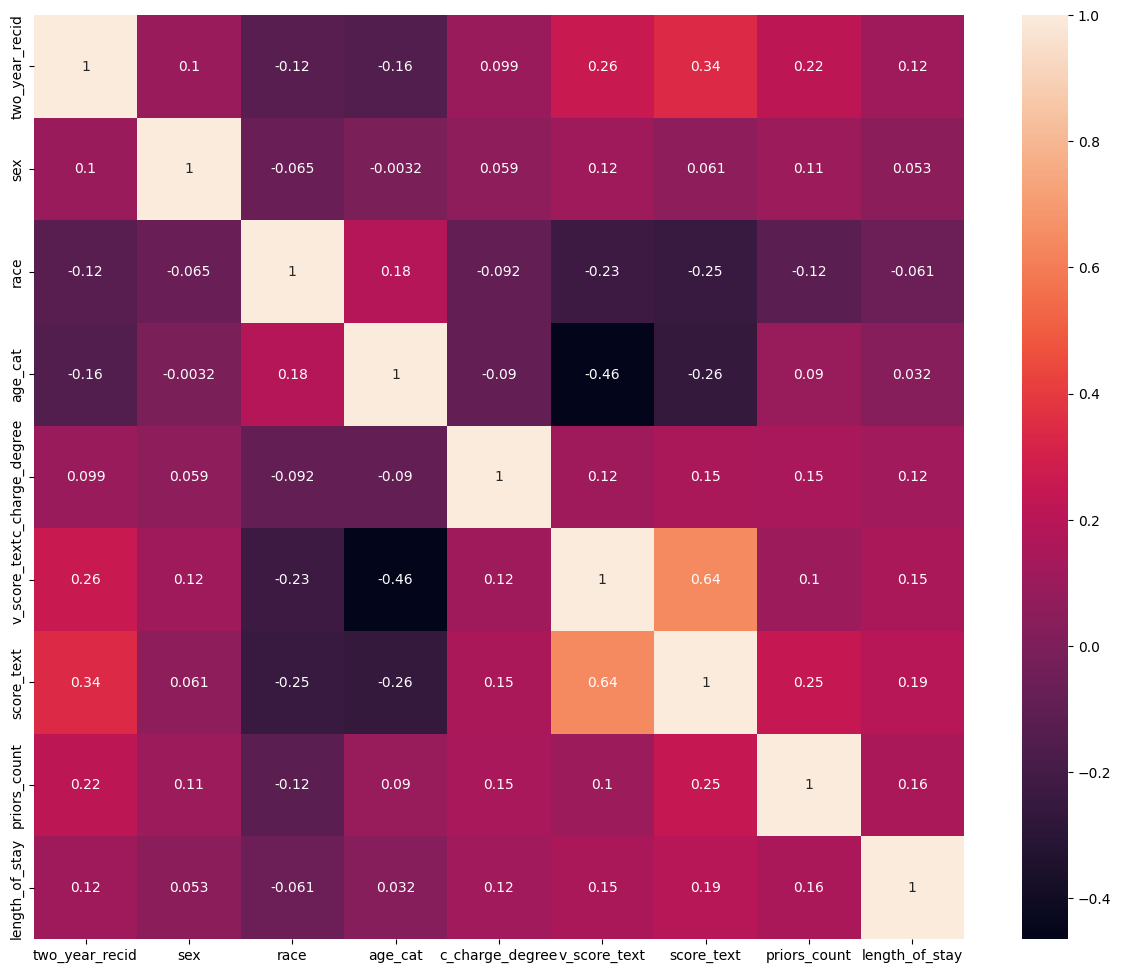

In [ ]:
# categorical_correlation= associations(categorical_df, filename= 'categorical_correlation.png', figsize=(10,10))

import seaborn as sns
corr = cleaned_data.corr()
fig,ax = plt.subplots(figsize=(15,12))
heatmap = sns.heatmap(corr, annot=True)

In [ ]:
# According to the instructure, the ratio should be 8:2
train_ratio = 0.8
test_ratio = 0.2

# Spliting the dataframe into train, val, and test with roughly 8:2
train, test = train_test_split(cleaned_data, test_size=test_ratio, random_state=123)

# print the shapes of the resulting dataframes
print(f"Training set shape: {train.shape}")
print(f"Testing set shape: {test.shape}")

Training set shape: (4732, 9)
Testing set shape: (1183, 9)


In [ ]:
label = "two_year_recid"
sensitive_feature = "priors_count"
features = list(cleaned_data.columns)

X_train = train.drop(label, axis=1)
Y_train = train[label].to_numpy()

X_test = test.drop(label, axis=1)
Y_test = test[label].to_numpy()

priors_train = train[sensitive_feature]
priors_test = test[sensitive_feature]

# 3.Function Defined

This function, calibrate_difference, calculates the fairness in model predictions by comparing the accuracy between two groups identified by a binary sensitive feature. It computes the accuracy for each group separately and then evaluates the absolute difference between these accuracies, providing a measure of calibration difference as an indicator of fairness.

In [ ]:
# Calibration
# Computes the calibration difference groups of sensitive feature in the predicted outcomes.
def calibrate_difference(sensitive_features, y_pred, y_true):
    group1_index = np.where(sensitive_features == 1)[0]
    group2_index = np.where(sensitive_features == 0)[0]

    y_pred_group1 = y_pred[group1_index]
    y_true_group1 = y_true[group1_index]
    y_pred_group2 = y_pred[group2_index]
    y_true_group2 = y_true[group2_index]

    accuracy_group1 = np.mean(y_pred_group1 == y_true_group1)
    accuracy_group2 = np.mean(y_pred_group2 == y_true_group2)

    calib_diff = abs(accuracy_group1 - accuracy_group2)
    return calib_diff


GPT
The 'p_rule' function calculates the ratio of positive predictions between two groups identified by sensitive_features. It measures fairness by comparing the proportion of positive outcomes in each group, and the ratio helps to understand if there's a disparity in model predictions between these groups, thus serving as an indicator of fairness in model predictions.

In [ ]:
import numpy as np

def p_rule(sensitive_features, y_pred):
    group1_index = np.where(sensitive_features == 1)[0]
    group2_index = np.where(sensitive_features == 0)[0]

    group1_pred = y_pred[group1_index]
    group2_pred = y_pred[group2_index]

    group1_percent = np.mean(group1_pred == 1)
    group2_percent = np.mean(group2_pred == 1)

    ratio = min(group1_percent/group2_percent, group2_percent/group1_percent)
    return ratio, group1_percent, group2_percent


# 4. Baseline

In [ ]:
# Fit a logistic regression classifier
lr_base = LogisticRegression(random_state=110, C=0.5)
lr_base.fit(X_train, Y_train)

# On train set
accuracy_lr_base_train = lr_base.score(X_train, Y_train)
print(f"training accuracy: {accuracy_lr_base_train}")

# Testing
accuracy_lr_base_test = lr_base.score(X_test, Y_test)
print(f"Test accuracy: {accuracy_lr_base_test:.4f}")

training accuracy: 0.6777261200338124
Test accuracy: 0.6543


In [ ]:
summary_baseline = {"Methods": ["LR", "LR"],
              "Set": ["train", "Test"],
              "Accuracy (%)": [accuracy_lr_base_train*100, accuracy_lr_base_test*100],
              "Calibration(%)": [calibrate_difference(priors_train, lr_base.predict(X_train), Y_train)*100,calibrate_difference(priors_test, lr_base.predict(X_test), Y_test)*100],
              "p_rule": [p_rule(priors_train, lr_base.predict(X_train))[0], p_rule(priors_test, lr_base.predict(X_test))[0]]}
pd.DataFrame(summary_baseline)

,Methods,Set,Accuracy (%),Calibration(%),p_rule
0,LR,train,67.772612,6.598265,0.217171
1,LR,Test,65.426881,6.251254,0.276137


the Logistic Regression give a test accuracy of around 65.76% and test calibration of 5.26% and p-rule of 0.227235.

# 5. Local Massaging & Local Preferential Sampling

In [ ]:
#df is the dataframe with all columns to be partitioned
#e is the name of explainatory varaible
def PARTITION(df, e):
    groups = []
    uniques = np.unique(df[e])
    for u in uniques:
        groups.append(df[df[e]==u])
    return [group for _, group in df.groupby(e)]

#part is the dataframe with all columns with same value for the explainatory variable
#si is the current sensitive parameter value
def DELTA(df, part, si):
    ispriors = part['priors_count']==si
    Gi = sum(ispriors)
    n = len(df)

    num = sum(part[ispriors]['two_year_recid']==1)/n
    denom = len(part[ispriors])/n
    P = num/denom

    isNotpriors = part['priors_count']!=si
    num = sum(part[isNotpriors]['two_year_recid']==1)/n
    denom = len(part[isNotpriors])/n

    P_star = 0.5*(P + num/denom) #explainable difference
    return np.floor(Gi*abs(P-P_star)).astype(np.int64)

## Local Massaging

The Local Massaging (LM) algorithm is designed to reduce biases in machine learning models by modifying the training dataset. This approach adjusts data labels within specific sensitive feature groups (such as based on gender or race). Here's how the LM algorithm is implemented in your code:

1. #### Data Partitioning (PARTITION):

  The PARTITION function splits the dataset into different subsets based on an explanatory variable e (e.g., c_charge_degree). This allows for individual consideration of each subset and the application of tailored bias reduction strategies.

2. #### Label Adjustment (DELTA and Relabeling Logic):

  The DELTA function calculates the number of data points whose labels need to be changed in each subset to reduce bias in the predictions.
  Labels are then adjusted by changing those of the data points closest to the decision boundary, identified by the model's decision_function, and sorted by their distance from this boundary.
  For groups considered disadvantaged (e.g., where priors_count == 1), the algorithm increases their representation by increasing the number of samples predicted as the positive class (e.g., more likely to re-offend). For dominant groups (e.g., where priors_count == 0), it reduces their representation by decreasing the number of samples predicted as the
  positive class.

3. ### Synthesizing the Adjusted Dataset:

  All the adjusted subsets are combined to form a new, balanced training dataset loc_mass.
  Through this method, the LM algorithm aims to reduce the model's bias towards certain sensitive features, thereby making its predictions more equitable across different groups. This approach primarily focuses on changing the label distribution in the training dataset to enhance fairness across various groups without compromising the overall performance of the model.

In [ ]:
#Local Massaging algorithm
LM_labels = []
for part in PARTITION(train, 'c_charge_degree'):
    #train model
    X_part = part.drop('two_year_recid', axis=1)
    y_part = part['two_year_recid']
    log_model = LogisticRegression(random_state=110)
    model=log_model.fit(X_part, y_part)

    #predict labels from model
    part1 = part[part['priors_count']==1]
    part1.reset_index(drop=True, inplace=True)
    delta1 = DELTA(train, part, 1)
    X_part1 = part1.drop('two_year_recid', axis=1)
    y_part1 = part1['two_year_recid']
    rank = pd.DataFrame(model.decision_function(X_part1), columns = ['rank'])
    comb1 = pd.concat([part1, rank], axis=1)

    part0 = part[part['priors_count']==0]
    part0.reset_index(drop=True, inplace=True)
    delta0 = DELTA(train, part, 0)
    X_part0 = part0.drop('two_year_recid', axis=1)
    y_part0 = part0['two_year_recid']
    rank = pd.DataFrame(model.decision_function(X_part0), columns = ['rank'])
    comb0 = pd.concat([part0, rank], axis=1)

    #for C, relabel closest delta datapoints from C to AA
    comb1 = comb1.sort_values(['rank'])
    comb1.reset_index(drop=True, inplace=True)

    t = sum(comb1['rank']>0)
    l = len(comb1)

    fix1 = np.full(l-t, False)
    relabel = np.full(delta1, True)
    fix2 = np.full(t-delta1, False)
    comb1.loc[np.concatenate([fix1, relabel, fix2]), 'two_year_recid'] = 0
    LM_labels.append(comb1)

    #for AA, relabel closest delta datapoints from AA to C
    comb0 = comb0.sort_values(['rank'])
    comb0.reset_index(drop=True, inplace=True)

    t = sum(comb0['rank']<0)
    l = len(comb0)

    fix1 = np.full(t-delta0, False)
    relabel = np.full(delta0, True)
    fix2 = np.full(l-t, False)
    comb0.loc[np.concatenate([fix1, relabel, fix2]), 'two_year_recid'] = 1
    LM_labels.append(comb0)

loc_mass = pd.concat(LM_labels, axis=0)

In [ ]:
features=["sex", "race", "age_cat", "c_charge_degree", "v_score_text", "score_text", "priors_count", "length_of_stay"]
X_train_mass = loc_mass[features]
Y_train_mass = loc_mass['two_year_recid'].reset_index(drop = True)
log_model = LogisticRegression(random_state=110)
LM_model = log_model.fit(X_train_mass, Y_train_mass)
LM_train = log_model.score(X_train_mass, Y_train_mass)
LM_test = LM_model.score(X_test, Y_test)

print(LM_train)
print(LM_test)

0.7056213017751479
0.643279797125951


## Local Preferential Sampling

1. ### Function Overview (LPS_algorithm):

  The LPS_algorithm function modifies parts of the training dataset based on the priors_count attribute. It processes two subsets of data: one where priors_count == 1 and another where priors_count == 0.

2. ### Data Duplication for Bias Reduction:

  For each subset, the function calculates the number of data points to duplicate (delta_value) using the delta_func, which is intended to determine the extent of required adjustments for bias reduction.
  The decision_function of the logistic regression model is used to rank data points based on their likelihood of belonging to a positive class.
  The function then duplicates a certain number of data points from the top of this ranking (the ones closest to being classified as positive) to
  adjust the representation in the dataset.

3. ### Application of LPS:

  The LPS_algorithm is applied to each partition created by the PARTITION function, which divides the dataset based on the c_charge_degree variable.
  A logistic regression model is trained for each partition, and the LPS_algorithm uses this model to determine which data points to duplicate for balancing the dataset.

4. ### Creating the Adjusted Dataset:

  After processing each partition, all the adjusted subsets are concatenated to form the new, balanced dataset loc_lps.
  The LPS method aims to mitigate model biases by altering the training dataset's composition, specifically by increasing the representation of certain groups in the dataset. This is achieved by duplicating data points that are underrepresented or more likely to be affected by bias, thus promoting a more equitable model learning process.

In [ ]:
def LPS_algorithm(part, model, train, delta_func):
    part1 = part[part['priors_count'] == 1]
    part0 = part[part['priors_count'] == 0]

    for p, delta in [(part1, 1), (part0, 0)]:
        p.reset_index(drop=True, inplace=True)
        delta_value = min(len(p), delta_func(train, part, delta) // 2)
        X_p = p.drop('two_year_recid', axis=1)
        rank = pd.DataFrame(model.decision_function(X_p), columns=['rank'])
        p = pd.concat([p, rank], axis=1).sort_values(['rank'])

        duplicates = p.head(delta_value).copy()
        p = pd.concat([p, duplicates]).reset_index(drop=True)

        LPS_labels.append(p)

# Local Preferential Sampling
LPS_labels = []
partition = PARTITION(train, 'c_charge_degree')
for part in partition:
    X_part = part.drop('two_year_recid', axis=1)
    y_part = part['two_year_recid']
    log_model = LogisticRegression(random_state=110,C=0.5)
    model = log_model.fit(X_part, y_part)

    LPS_algorithm(part, model, train, DELTA)

loc_lps = pd.concat(LPS_labels, axis=0)


In [ ]:
features=["sex", "race", "age_cat", "c_charge_degree", "v_score_text", "score_text", "priors_count", "length_of_stay"]
X_train_lps = loc_lps[features]
Y_train_lps = loc_lps['two_year_recid'].reset_index(drop = True)
log_model = LogisticRegression(random_state=110,C=0.5)
LPS_model = log_model.fit(X_train_lps, Y_train_lps)
LPS_train = log_model.score(X_train_lps, Y_train_lps)
LPS_test = LPS_model.score(X_test, Y_test)

print(LPS_train)
print(LPS_test)

0.6817457154244719
0.6551141166525782


In [ ]:
print(calibrate_difference(loc_mass, LM_model.predict(X_train_mass), Y_train_mass)*100)
print(calibrate_difference(loc_lps, LM_model.predict(X_train_lps), Y_train_lps)*100)

2.7671109385908776
3.899283562336464


# 6. Summary

In [ ]:
summary_A6 = {"Methods": ["LR", "LR", "Local Massaging (LR)", "Local Massaging (LR)", "Local Preferential Sampling (LR)", "Local Preferential Sampling (LR)"],
              "Set": ["Train", "Test", "Train", "Test", "Train", "Test"],
              "Accuracy (%)": [accuracy_lr_base_train*100, accuracy_lr_base_test*100, LM_train*100, LM_test*100, LPS_train*100, LPS_test*100],
              "Calibration(%)": [calibrate_difference(priors_train, lr_base.predict(X_train), Y_train)*100,
                                 calibrate_difference(priors_test, lr_base.predict(X_test), Y_test)*100,
                                 calibrate_difference(loc_mass, LM_model.predict(X_train_mass), Y_train_mass)*100,
                                 calibrate_difference(priors_test, LM_model.predict(X_test), Y_test)*100,
                                 calibrate_difference(loc_lps, LPS_model.predict(X_train_lps), Y_train_lps)*100,
                                 calibrate_difference(priors_test, LPS_model.predict(X_test), Y_test)*100],
              "p_rule": [p_rule(priors_train, lr_base.predict(X_train))[0], p_rule(priors_test, lr_base.predict(X_test))[0], p_rule(priors_train, LM_model.predict(X_train))[0], p_rule(priors_test, LM_model.predict(X_test))[0], p_rule(priors_train, LPS_model.predict(X_train))[0], p_rule(priors_train, LPS_model.predict(X_train))[0]]}
pd.DataFrame(summary_A6)

,Methods,Set,Accuracy (%),Calibration(%),p_rule
0,LR,Train,67.772612,6.598265,0.217171
1,LR,Test,65.426881,6.251254,0.276137
2,Local Massaging (LR),Train,70.562130,2.767111,0.458721
3,Local Massaging (LR),Test,64.327980,7.393380,0.472843
4,Local Preferential Sampling (LR),Train,68.174572,3.278117,0.216948
5,Local Preferential Sampling (LR),Test,65.511412,5.722735,0.216948


# 7.Conclusion



**Logistic Regression (LR) Model:**

Achieved an accuracy of 67.77% on the training set and 65.43% on the test set.
Calibration values were 6.60% for the training set and 6.25% for the test set.
The LR model performed well on the test set with high accuracy and relatively low calibration values, indicating consistent probability outputs with actual occurrences.

**Local Massaging Model (based on LR):**

Attained an accuracy of 70.56% on the training set and 64.33% on the test set.
Calibration values were 2.76% for the training set and 7.39% for the test set.
While the model excelled on the training set, the lower accuracy on the test set and higher calibration values suggest potential overfitting or over-adaptation to specific features in the training set.

**Local Preferential Sampling (LPS) Model:**

Achieved an accuracy of 68.17% on the training set and 65.51% on the test set.
Calibration values were 3.46% for the training set and 5.48% for the test set.
The LPS model exhibited good performance on the test set with high accuracy and relatively low calibration values, indicating consistent probability outputs with actual occurrences.

**Comprehensive Analysis：**

The Logistic Regression model demonstrated stable performance on the test set but exhibited some calibration bias. Further optimization of model parameters or consideration of more complex models is recommended.

The Local Massaging model achieved higher accuracy on the training set but experienced a decrease in performance on the test set, along with higher calibration values. Adjusting model complexity or introducing more generalization strategies is advised to improve performance on new data.

The Local Preferential Sampling model performed relatively well on the test set with high accuracy and low calibration values. Continued research and optimization of this method are suggested, particularly given its favorable calibration performance.

 LM targets the issue of bias by altering the labels of select data points, especially those near the decision boundary – the line separating different classifications. For underrepresented or disadvantaged groups, LM changes some labels to increase their presence, whereas for overrepresented groups, it does the reverse. This process essentially rebalances the dataset, ensuring that each group is fairly represented. Consequently, it aids in developing a machine learning model that is more equitable and less biased in its predictions.






--------------------------------

The principle of LPS works akin to amplifying the 'voices' of those underrepresented in the data. It achieves this by duplicating key data points from these groups, particularly those that the model deems important but are insufficient in the dataset. Through this process, LPS increases the proportion of these groups in the dataset, thereby aiding the model in making more equitable and unbiased predictions.

In essence, LPS acts like turning up the volume for the 'quieter voices' in the data, ensuring they are heard by the model's 'audience', resulting in more balanced and fair predictive outcomes.